# Laboratorium 8. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [55]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


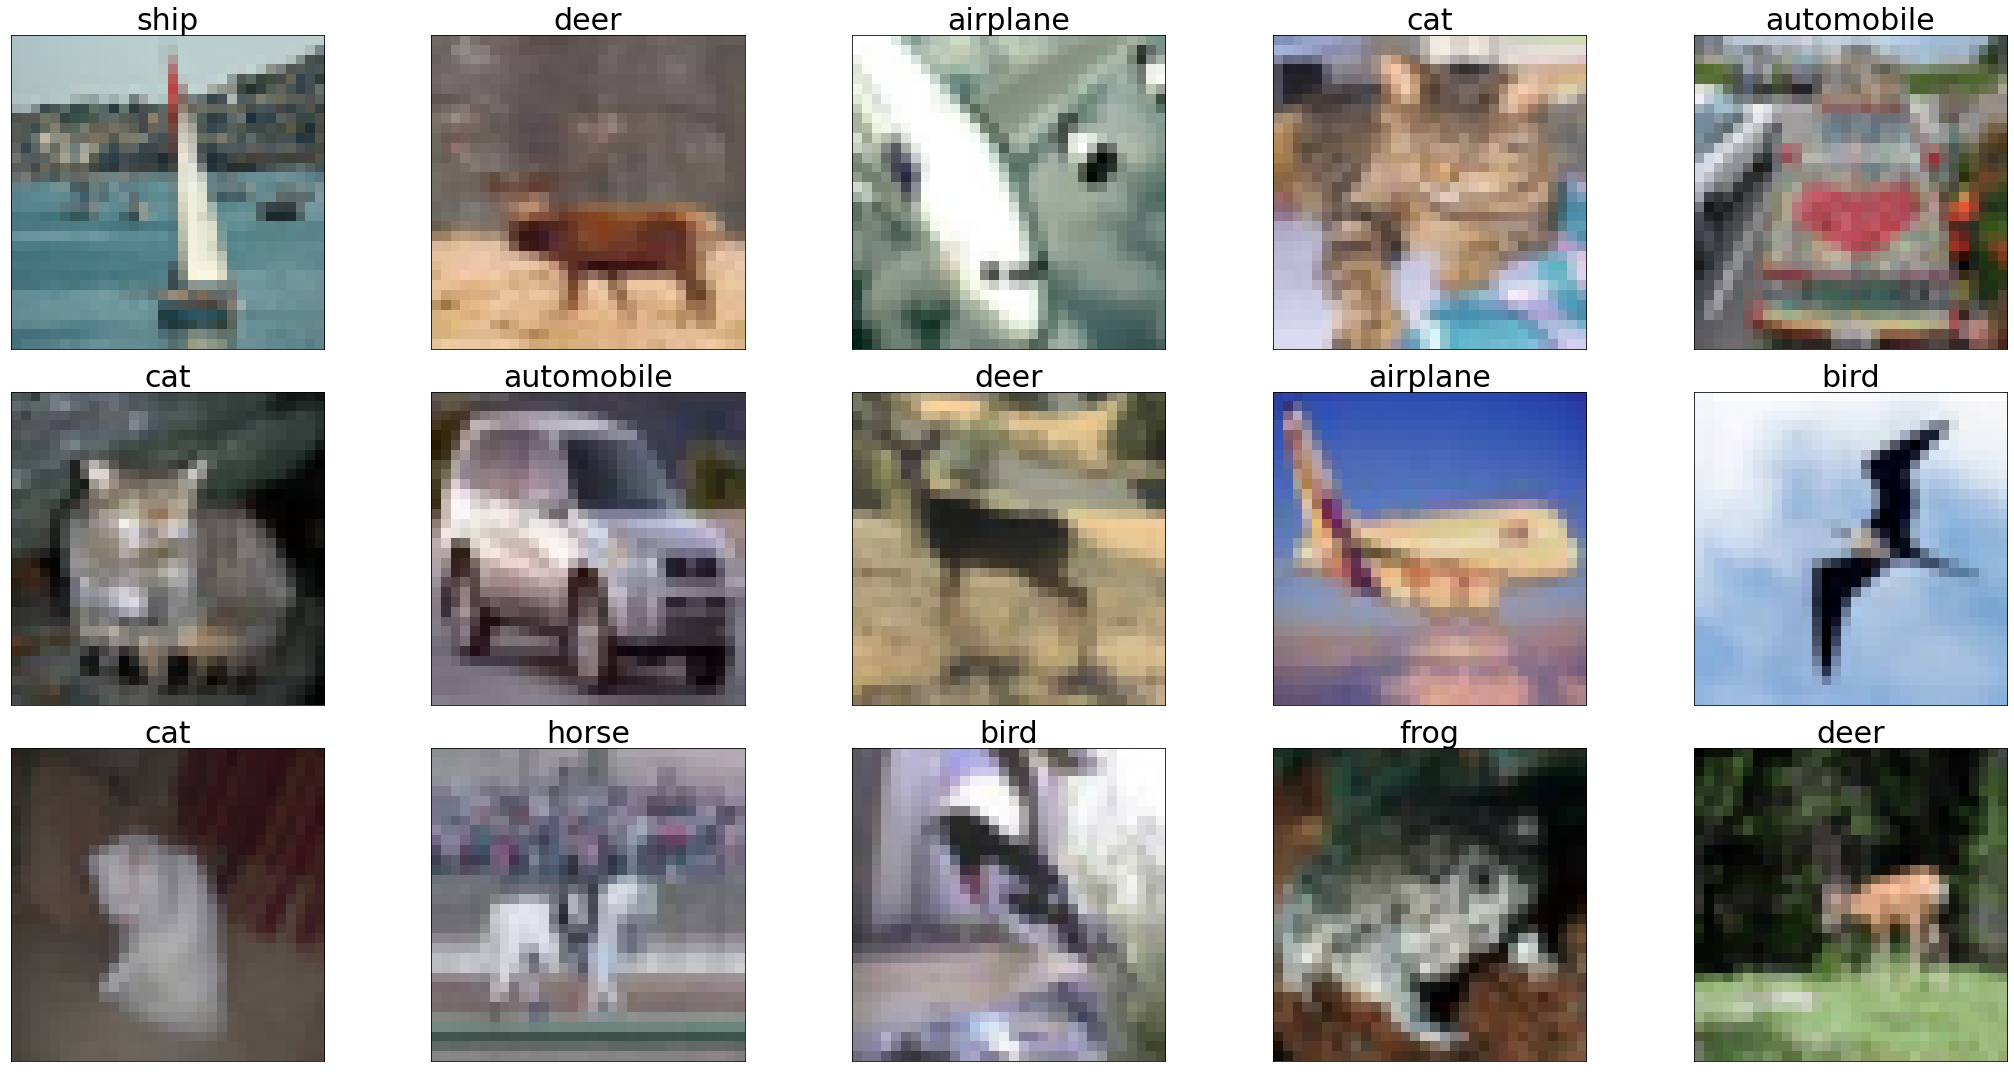

In [56]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [57]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module

import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    @staticmethod
    def _make_layers():
        return nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(3, 32, kernel_size=3, padding=1)),
          ('bn1', nn.BatchNorm2d(32)),
          ('relu1', nn.ReLU(inplace=True)),
          ('maxpool1', nn.MaxPool2d(kernel_size=2, stride=2)),
          ('conv2', nn.Conv2d(32, 64, kernel_size=3, padding=1)),
          ('bn2', nn.BatchNorm2d(64)),
          ('relu2', nn.ReLU(inplace=True)),
          ('maxpool2', nn.MaxPool2d(kernel_size=2, stride=2)),
          ('conv3', nn.Conv2d(64, 128, kernel_size=3, padding=1)),
          ('bn3', nn.BatchNorm2d(128)),
          ('relu3', nn.ReLU(inplace=True)),
          ('maxpool3', nn.MaxPool2d(kernel_size=2, stride=2)),
          ('avrpool', nn.AvgPool2d(kernel_size=1, stride=1))
        ]))

In [58]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

transforms = Compose([
  ToTensor(),
  transforms.Normalize((0, 0, 0), (1, 1, 1))
])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transforms)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transforms)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [59]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
cuda = torch.cuda.is_available();

net = Net()
if cuda:
    net.cuda()

learning_rate = 0.001
momentum = 0.9
epochs = 50

criteria  = nn.CrossEntropyLoss()
optimization = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(epochs):
    net.train()

    all_loss = 0
    correct_answers = 0
    all_inputs = 0
    minibatches_number = 0
# start training in epoch

    for inputs, labels in train_loader:
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        optimization.zero_grad()

        outputs = net(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimization.step()

        _, predicted = torch.max(outputs.data, 1)

        all_inputs += labels.size(0)
        correct_answers += predicted.eq(labels.data).cpu().sum()
        all_loss += loss.item()
        minibatches_number += 1
  
    print(f'[epoch {epoch}] train loss: {all_loss / minibatches_number :.3f} | train acc: {100. * correct_answers / all_inputs :.3f}%')

    all_loss = 0
    correct_answers = 0
    all_inputs = 0
    minibatches_number = 0

# start testing

    for inputs, labels in test_loader:
        if cuda:
              inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)

        all_inputs += labels.size(0)
        correct_answers += predicted.eq(labels.data).cpu().sum()
        all_loss += loss.item()
        minibatches_number += 1

    print(f'[epoch {epoch}] test loss: {all_loss/minibatches_number :.3f} | test acc: {100. * correct_answers / all_inputs :.3f}%')
  


[epoch 0] train loss: 1.329 | train acc: 52.624%
[epoch 0] test loss: 1.089 | test acc: 61.330%
[epoch 1] train loss: 0.981 | train acc: 65.828%
[epoch 1] test loss: 0.955 | test acc: 67.140%
[epoch 2] train loss: 0.847 | train acc: 70.744%
[epoch 2] test loss: 0.886 | test acc: 69.610%
[epoch 3] train loss: 0.764 | train acc: 73.684%
[epoch 3] test loss: 0.845 | test acc: 70.240%
[epoch 4] train loss: 0.698 | train acc: 76.048%
[epoch 4] test loss: 0.787 | test acc: 72.880%
[epoch 5] train loss: 0.638 | train acc: 78.432%
[epoch 5] test loss: 0.777 | test acc: 73.290%
[epoch 6] train loss: 0.591 | train acc: 79.784%
[epoch 6] test loss: 0.795 | test acc: 72.930%
[epoch 7] train loss: 0.554 | train acc: 81.056%
[epoch 7] test loss: 0.752 | test acc: 74.580%
[epoch 8] train loss: 0.508 | train acc: 83.006%
[epoch 8] test loss: 0.779 | test acc: 74.070%
[epoch 9] train loss: 0.474 | train acc: 84.142%
[epoch 9] test loss: 0.772 | test acc: 74.050%
[epoch 10] train loss: 0.439 | train acc

## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

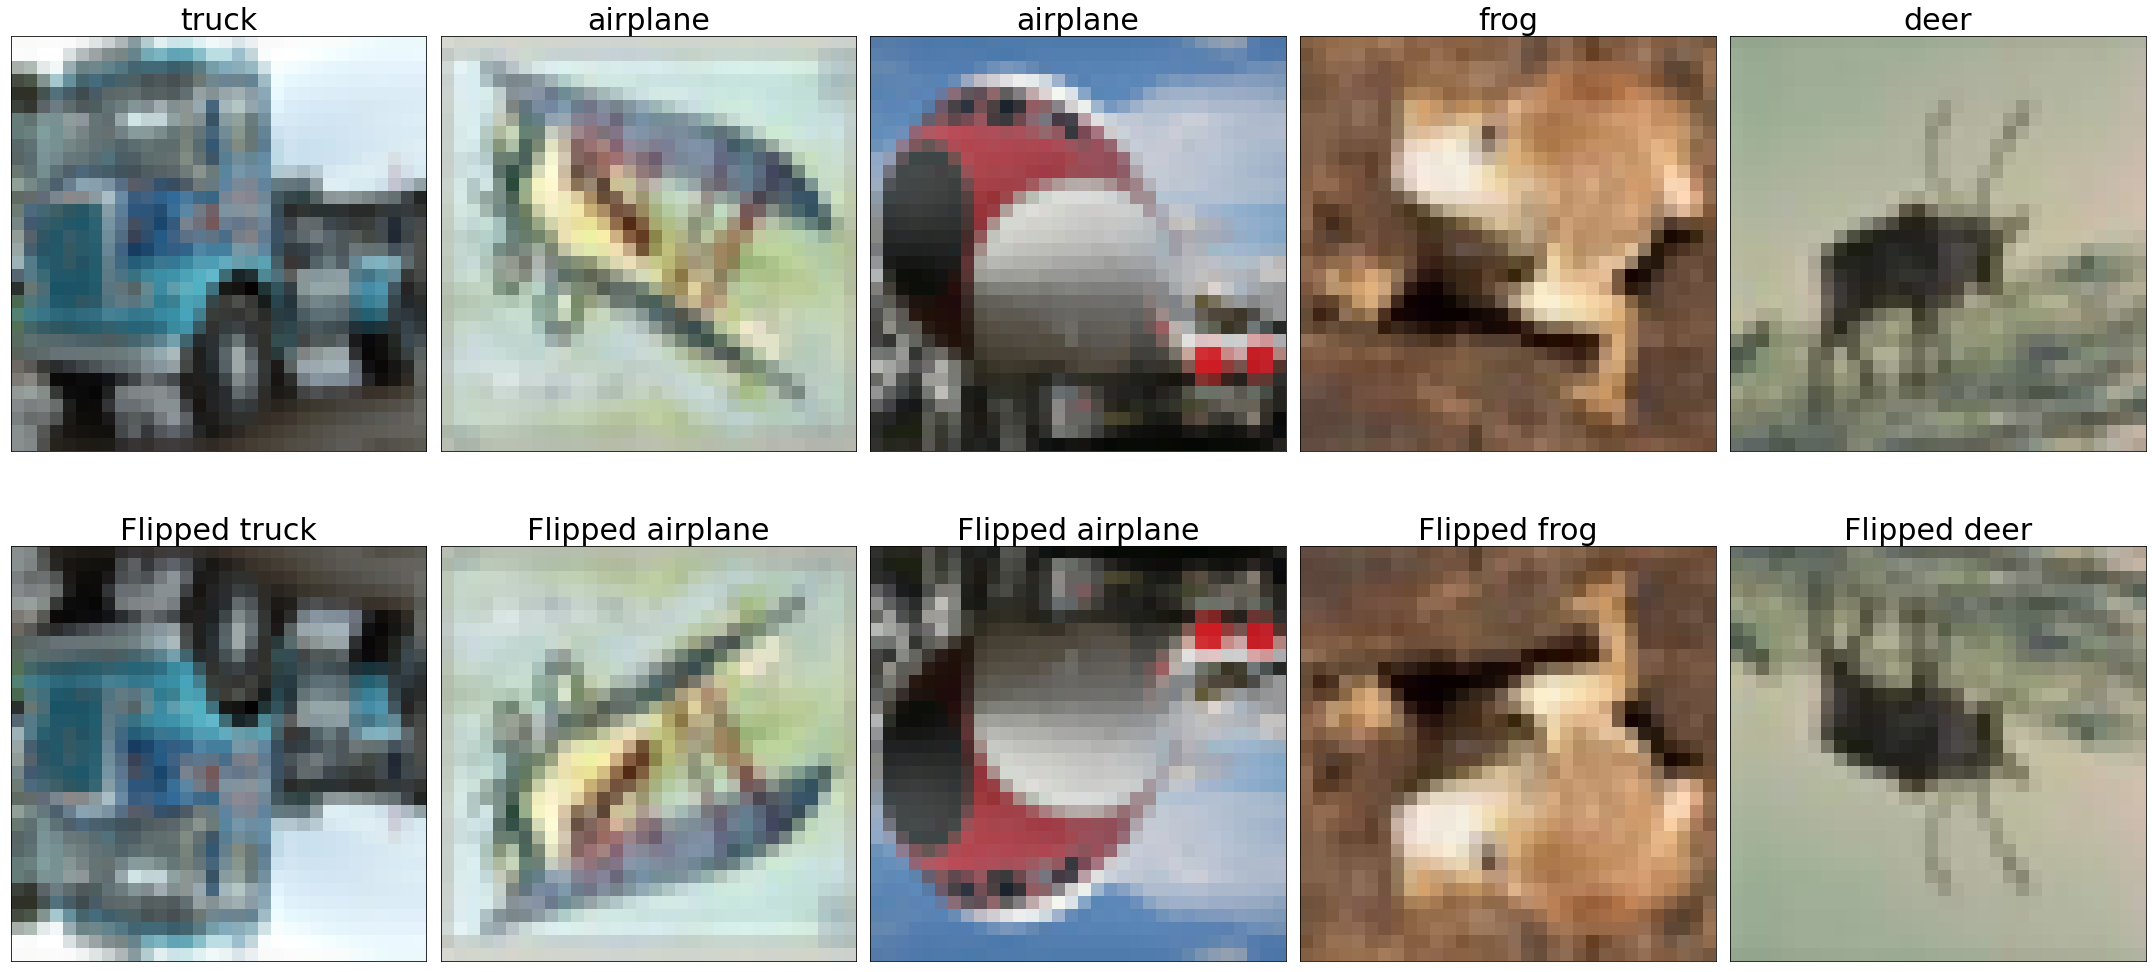

In [60]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [63]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
import torchvision.transforms as transforms

transforms_augmentation = Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomAffine((-10, 10), (.1, .1)),
  ToTensor(),
  transforms.Normalize((0, 0, 0), (1, 1, 1))
])


train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transforms_augmentation)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transforms_augmentation)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# tutaj powtórz pętle uczenia z poprzedniego zadania

cuda = torch.cuda.is_available();

net = Net()
if cuda:
    net.cuda()

learning_rate = 0.001
momentum = 0.9
epochs = 50

criteria  = nn.CrossEntropyLoss()
optimization = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(epochs):
    net.train()

    all_loss = 0
    correct_answers = 0
    all_inputs = 0
    minibatches_number = 0
# start training in epoch

    for inputs, labels in train_loader:
        if cuda:
              inputs, labels = inputs.cuda(), labels.cuda()
        optimization.zero_grad()

        outputs = net(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimization.step()

        _, predicted = torch.max(outputs.data, 1)

        all_inputs += labels.size(0)
        correct_answers += predicted.eq(labels.data).cpu().sum()
        all_loss += loss.item()
        minibatches_number += 1
  
    print(f'[epoch {epoch}] train loss: {all_loss / minibatches_number :.3f} | train acc: {100. * correct_answers / all_inputs :.3f}%')

    all_loss = 0
    correct_answers = 0
    all_inputs = 0
    minibatches_number = 0

# start testing

    for inputs, labels in test_loader:
        if cuda:
              inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)

        all_inputs += labels.size(0)
        correct_answers += predicted.eq(labels.data).cpu().sum()
        all_loss += loss.item()
        minibatches_number += 1

    print(f'[epoch {epoch}] test loss: {all_loss/minibatches_number :.3f} | test acc: {100. * correct_answers / all_inputs :.3f}%')

[epoch 0] train loss: 1.497 | train acc: 45.762%
[epoch 0] test loss: 1.258 | test acc: 54.990%
[epoch 1] train loss: 1.198 | train acc: 57.534%
[epoch 1] test loss: 1.161 | test acc: 58.810%
[epoch 2] train loss: 1.074 | train acc: 62.302%
[epoch 2] test loss: 1.021 | test acc: 64.540%
[epoch 3] train loss: 1.008 | train acc: 64.652%
[epoch 3] test loss: 0.973 | test acc: 65.840%
[epoch 4] train loss: 0.953 | train acc: 66.546%
[epoch 4] test loss: 0.925 | test acc: 67.630%
[epoch 5] train loss: 0.913 | train acc: 68.168%
[epoch 5] test loss: 0.876 | test acc: 69.630%
[epoch 6] train loss: 0.878 | train acc: 69.280%
[epoch 6] test loss: 0.876 | test acc: 69.740%
[epoch 7] train loss: 0.849 | train acc: 70.586%
[epoch 7] test loss: 0.859 | test acc: 69.830%
[epoch 8] train loss: 0.826 | train acc: 71.314%
[epoch 8] test loss: 0.872 | test acc: 70.550%
[epoch 9] train loss: 0.804 | train acc: 71.780%
[epoch 9] test loss: 0.876 | test acc: 70.030%
[epoch 10] train loss: 0.782 | train acc

## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci w takim sposób aby uzyskać błędne, a nawet specyficzne wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [28]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [29]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2022-23/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

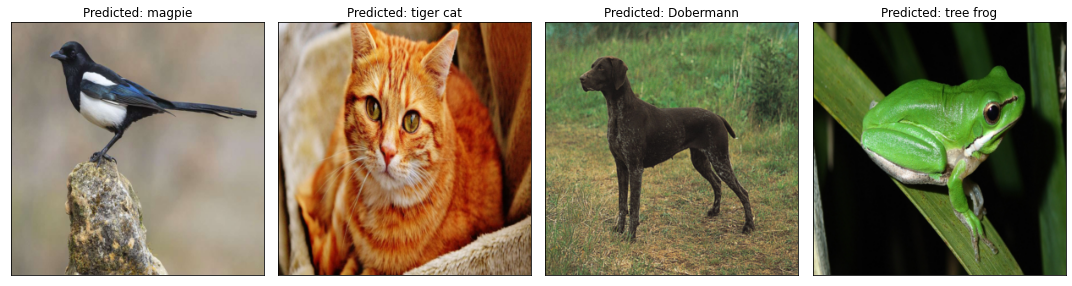

In [30]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [37]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.2

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

In [38]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizację znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji.

FGSM zmienia predykcję dla Sroki dla epsilon = 0.2

In [51]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizację!
import matplotlib.pyplot as plt

dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [53]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych
for x, y in loader:
  loss = nn.CrossEntropyLoss()
  eps = 0.03

  x.requires_grad = True

  if cuda:
    x, y = x.cuda(), y.cuda()
  outputs = net(x)
  cost = loss(outputs, y)

  # get input gradients
  grad = torch.autograd.grad(cost, x, create_graph=False)[0]

  # FGSM 
  adv_imgs = x + eps * grad.sign()
  # clamp to the image range
  adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
  # save gradients for visualisation
  grads = torch.clamp(grad.sign(), min=0, max=1).detach()

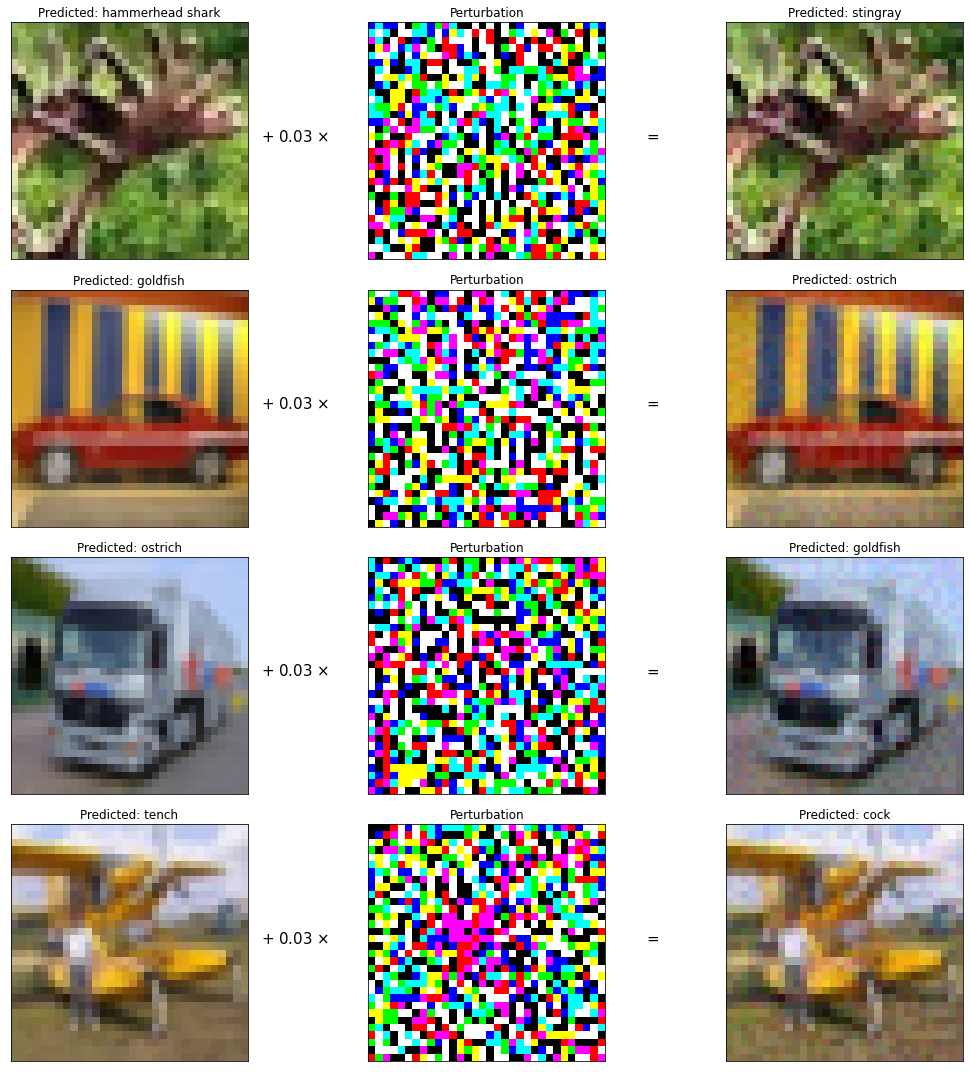

In [54]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu

output = net(adv_imgs)
adv_pred = torch.argmax(output, 1)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, x, adv_imgs, y, adv_pred, grads):
    row[0].imshow(np.transpose(img.cpu().detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g.cpu(), (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.cpu().detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()